In [1]:
import numpy as np
import pandas as pd
from math import ceil
import pickle
import random
with open('datapath.txt','r') as f:
    datapath=f.readlines()[0].rstrip()

In [2]:
with open('Cliente_ID_Stats.pkl','r') as f:
    cuenta_Cliente=pickle.load(f)

In [3]:
cuenta_Cliente.sort_values(ascending=False,inplace=True)

I'm going to focus on just one client: the most common one.

In [4]:
myclient=cuenta_Cliente.index[0]

In [5]:
pd.read_csv(datapath+'cliente_tabla.csv.zip',index_col='Cliente_ID').loc[cuenta_Cliente.index[:20]]

,NombreCliente
Cliente_ID,
653378,PUEBLA REMISION
653039,QUERETARO DE ARTEAGA REMISION
652850,JALISCO REMISION
652889,CHIHUAHUA REMISION
1093627,SUPERAMA RIO MAYO
653124,TAMAULIPAS REMISION
625491,SOMAKI DE MEXICO 8644
5903732,WAL MART SUPER CENTER DOMINGO DIEZ CUERNAVACA
652940,GUANAJUATO REMISION


It seems like this top one is the "remisión" for the state of Puebla (the one south-east of Mexico City). I'm not entirely sure what this means. Google translate says "remission" or "remital", both words I had to look up. The first definition in the rae dictionary is "Something sent to a specific person somewhere else", which I think is the "remital" one, while the others have to do with pardoning/suspending some sort of obligation, which I think corresponds to "remission".

Anyway, these seem to not be particular retailers, unlike, say, "Superama Rio Mayo", which comes up in a Google search as a supermarket in a suburb south of Mexico City.

In [6]:
cuenta_Cliente[myclient]

124059

In [7]:
traindtypes=pd.read_csv(datapath+'train.csv',nrows=10,parse_dates=False).dtypes.to_dict()
traindtypes['Semana']=np.uint8

In [8]:
traincols=pd.read_csv(datapath+'train.csv',nrows=10,parse_dates=False).columns

I already looked at the data, and these were the only columns with multiple values within this client id that are present in the test file.

In [9]:
useful_features='Agencia_ID Producto_ID Ruta_SAK Semana'.split()
useful_columns='Agencia_ID Producto_ID Ruta_SAK Semana Demanda_uni_equil'.split()

In [10]:
train=pd.DataFrame(columns=useful_columns+['Cliente_ID'])

In [11]:
chunksz=400000

In [12]:
trainit=pd.read_csv(datapath+'train.csv',parse_dates=False,dtype=traindtypes,chunksize=chunksz,iterator=True,usecols=useful_columns+['Cliente_ID'])

In [13]:
%%time
i=0
for chunk in trainit:
    if i%50==0:
        print(i)
    train=train.append(chunk[chunk['Cliente_ID']==myclient],ignore_index=True)
    i+=1
    

0
50
100
150
CPU times: user 47.9 s, sys: 4.17 s, total: 52.1 s
Wall time: 54.8 s


In [14]:
train.describe()

,Agencia_ID,Cliente_ID,Demanda_uni_equil,Producto_ID,Ruta_SAK,Semana
count,124059.000000,124059.0,124059.000000,124059.000000,124059.000000,124059.000000
mean,2055.076585,653378.0,144.013929,29586.685633,3009.092246,5.999831
std,1025.075220,0.0,149.659065,16379.587461,10.277078,2.002544
min,1228.000000,653378.0,0.000000,1216.000000,3001.000000,3.000000
25%,1255.000000,653378.0,54.000000,7814.000000,3003.000000,4.000000
50%,1650.000000,653378.0,110.000000,34389.000000,3006.000000,6.000000
75%,2231.000000,653378.0,187.000000,43069.000000,3011.000000,8.000000
max,4091.000000,653378.0,2830.000000,49769.000000,3059.000000,9.000000


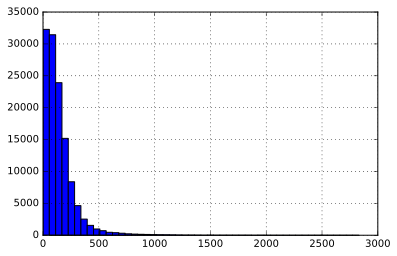

In [15]:
train['Demanda_uni_equil'].hist(bins=50)


This is a terrible distribution to do regression on. It looks close to exponential, and includes values at zero. Informed by our scoring metric, I'm going to take a look at $\log(demand + 1)$

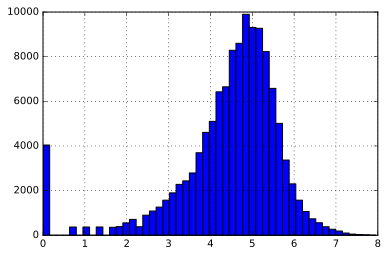

In [16]:
np.log(train['Demanda_uni_equil']+1.0).hist(bins=50)

Not too shabby: Apart from the spike at zero, this looks a little close to a normal distribution. For now, I'm not going to worry about that spike.

In [17]:
{i:train[i].unique().shape[0] for i in train.columns}

{'Agencia_ID': 62,
 'Cliente_ID': 1,
 'Demanda_uni_equil': 1346,
 'Producto_ID': 212,
 'Ruta_SAK': 47,
 'Semana': 7}

In [18]:
y=np.log(train['Demanda_uni_equil']+1.0)

In [19]:
#convert to category variables
for i in useful_features:
    cats=train[i].unique().tolist()
    train.loc[:,i]=train[i].astype('category',categories=cats)
    

In [20]:
#get rid of Cliente_ID
train=train[useful_columns]

This is the process that takes a lot of time if you have lots of different categories: Dummifying the variables.

I'm not sure if R will do this faster. I happen to know off the top of my head that R's Random Forest model can't deal with more than 32 factors.

In [21]:
%%time
X=pd.get_dummies(train[useful_features],sparse=True,prefix_sep=':')

CPU times: user 1.62 s, sys: 246 µs, total: 1.62 s
Wall time: 1.61 s


In [22]:
def standardize(s):
    if s.std()>0.0:
        return ((s-s.mean())/s.std())
    else:
        return s

In [23]:
X=X.apply(standardize,axis='index')

In [24]:
from sklearn.metrics import mean_squared_error

def rmse(estimator, X, y):
    y_pred=estimator.predict(X)
    return np.sqrt(mean_squared_error(y_pred,y))

## ElasticNet

In [65]:
from sklearn.linear_model import ElasticNetCV

In [67]:
enet=ElasticNetCV(n_alphas=20)

In [174]:
%time enet.fit(X,y)

CPU times: user 15.4 s, sys: 12.3 s, total: 27.7 s
Wall time: 10.7 s


ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=20, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [175]:
enet.alpha_

0.0057824574089364485

Mostly L1 regularization.

In [195]:
#This is the same score as the kaggle score, as we already took the log
rmse(enet,X,y)

0.96327065574977888

Ok, that could be better. But we don't have the client id as a predictor, so it's not a great comparison.

In [192]:
from sklearn.cross_validation import cross_val_score

In [197]:
cross_val_score?

In [198]:
%time cvscore_logenet=cross_val_score(enet,X,y,scoring=rmse,cv=5)

CPU times: user 1min 4s, sys: 50.2 s, total: 1min 54s
Wall time: 44.2 s


In [199]:
cvscore_logenet

array([ 0.95151178,  0.99752119,  0.96322927,  0.9714726 ,  1.12439721])

In [ ]:
try:
    cvscore_logenet
except NameError:
    cvscore_logenet=[ 0.95151178,  0.99752119,  0.96322927,  0.9714726 ,  1.12439721]

Note: this is about 0.1 lower than if we just use raw `Demanda_uni_equil`, with a pval of about 3.2%

In [205]:
coefs=pd.DataFrame(pd.Series({i[0]:i[1] for i in zip(X.columns,enet.coef_)},name='coef'))

In [206]:
coefs['abs']=np.abs(coefs['coef'])

In [207]:
coefs.sort_values('abs',ascending=False,inplace=True)

In [212]:
coefs=coefs.join(coefs.index.to_series().str.split(':',expand=True))

In [214]:
coefs.columns=[u'coef', u'abs', 'feature', 'category']

In [217]:
coefs.head(10)

,coef,abs,feature,category
Producto_ID:5200.0,0.243779,0.243779,Producto_ID,5200.0
Agencia_ID:2274.0,-0.233658,0.233658,Agencia_ID,2274.0
Producto_ID:30384.0,0.169928,0.169928,Producto_ID,30384.0
Producto_ID:1250.0,0.161887,0.161887,Producto_ID,1250.0
Producto_ID:42128.0,0.144443,0.144443,Producto_ID,42128.0
Producto_ID:49735.0,-0.129162,0.129162,Producto_ID,49735.0
Producto_ID:49736.0,-0.125395,0.125395,Producto_ID,49736.0
Producto_ID:40985.0,0.116850,0.116850,Producto_ID,40985.0
Producto_ID:43074.0,0.111906,0.111906,Producto_ID,43074.0
Producto_ID:5430.0,0.103406,0.103406,Producto_ID,5430.0


In [216]:
coefs.groupby('feature').mean()['abs']

feature
Agencia_ID     0.024540
Producto_ID    0.034255
Ruta_SAK       0.010830
Semana         0.012646
Name: abs, dtype: float64

We can see that `Producto_ID` seems to be the most predictive feature. Nine of the top 10 most predictive categories are products, and product has the highest mean.

This gives the ratio of the categories that have been eliminated by the elastic net regularization:

In [224]:
(coefs[coefs['abs']==0.0].groupby('feature').size())/(coefs.groupby('feature').size())

feature
Agencia_ID     0.080645
Producto_ID    0.099057
Ruta_SAK       0.276596
Semana         0.285714
dtype: float64

By this measure, `Agencia_ID` is a bit more predictive than `Producto_ID`, but they are close.

Eliminating individual categories within features isn't necessarily the best practice. But we have so many categories that we need to eliminate some of them, so I'm not too worried about it.

In [223]:
{3:'Thu',4:'Fri',5:'Sat',6:'Sun',7:'Mon',8:'Tue',9:'Wed'}

{3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun', 7: 'Mon', 8: 'Tue', 9: 'Wed'}

In [226]:
coefs[coefs['feature']=='Semana']

,coef,abs,feature,category
Semana:6.0,-0.045114,0.045114,Semana,6.0
Semana:8.0,-0.017547,0.017547,Semana,8.0
Semana:4.0,0.015606,0.015606,Semana,4.0
Semana:7.0,-0.008599,0.008599,Semana,7.0
Semana:3.0,0.001655,0.001655,Semana,3.0
Semana:5.0,0.000000,0.000000,Semana,5.0
Semana:9.0,0.000000,0.000000,Semana,9.0


Day of the week doesn't seem to be particularly useful

In [225]:
coefs[coefs['abs']==0.0]

,coef,abs,feature,category
Agencia_ID:1250.0,0.0,0.0,Agencia_ID,1250.0
Ruta_SAK:3027.0,0.0,0.0,Ruta_SAK,3027.0
Ruta_SAK:3047.0,0.0,0.0,Ruta_SAK,3047.0
Ruta_SAK:3045.0,0.0,0.0,Ruta_SAK,3045.0
Agencia_ID:1673.0,-0.0,0.0,Agencia_ID,1673.0
Ruta_SAK:3051.0,-0.0,0.0,Ruta_SAK,3051.0
Ruta_SAK:3042.0,0.0,0.0,Ruta_SAK,3042.0
Ruta_SAK:3035.0,0.0,0.0,Ruta_SAK,3035.0
Ruta_SAK:3039.0,-0.0,0.0,Ruta_SAK,3039.0
Semana:5.0,0.0,0.0,Semana,5.0


In [117]:
(coefs['coef']==0.0).sum()

51

## Random Forest

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV

In [26]:
rfr=RandomForestRegressor(n_jobs=2)

In [27]:
np.linspace

<function numpy.core.function_base.linspace>

In [28]:
params1={'max_features':np.linspace(0.1,1.0,num=3),
       'max_depth':np.linspace(10,100,num=3,dtype=int).tolist()+[None],
       }
params2={'min_samples_split':np.linspace(2,10,num=4),
        'min_weight_fraction_leaf':np.linspace(0.0,0.5,num=4),
}
#        'max_leaf_nodes':np.linspace(10,1000,num=4,dtype=int).tolist()+[None]

In [29]:
params1

{'max_depth': [10, 55, 100, None],
 'max_features': array([ 0.1 ,  0.55,  1.  ])}

In [30]:
GridSearchCV?

In [31]:
(3*3*4)

36

In [32]:
grid=GridSearchCV(rfr,params1,n_jobs=1,pre_dispatch=1)
%time grid.fit(X,y)

CPU times: user 22min 12s, sys: 8.33 s, total: 22min 20s
Wall time: 11min 33s


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=2, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': array([ 0.1 ,  0.55,  1.  ]), 'max_depth': [10, 55, 100, None]},
       pre_dispatch=1, refit=True, scoring=None, verbose=0)

In [35]:
rfr = grid.best_estimator_
grid=GridSearchCV(rfr,params2,n_jobs=1,pre_dispatch=1)
%time grid.fit(X,y)

CPU times: user 10min 59s, sys: 7.69 s, total: 11min 6s
Wall time: 5min 59s


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.55000000000000004, max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': array([  2.     ,   4.66667,   7.33333,  10.     ]), 'min_weight_fraction_leaf': array([ 0.     ,  0.16667,  0.33333,  0.5    ])},
       pre_dispatch=1, refit=True, scoring=None, verbose=0)

In [45]:
n_ests={'n_estimators':np.logspace(2,4,num=3,dtype=int)}

In [46]:
n_ests

{'n_estimators': array([  100,  1000, 10000])}

In [41]:
rfr

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.55000000000000004, max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=4.6666666666666661,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [40]:
rfr=grid.best_estimator_


AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [49]:
import joblib

In [51]:
joblib.dump(rfr,'top_client_random_forest.pkl')

['top_client_random_forest.pkl',
 'top_client_random_forest.pkl_01.npy',
 'top_client_random_forest.pkl_02.npy',
 'top_client_random_forest.pkl_03.npy',
 'top_client_random_forest.pkl_04.npy',
 'top_client_random_forest.pkl_05.npy',
 'top_client_random_forest.pkl_06.npy',
 'top_client_random_forest.pkl_07.npy',
 'top_client_random_forest.pkl_08.npy',
 'top_client_random_forest.pkl_09.npy',
 'top_client_random_forest.pkl_10.npy',
 'top_client_random_forest.pkl_11.npy',
 'top_client_random_forest.pkl_12.npy',
 'top_client_random_forest.pkl_13.npy',
 'top_client_random_forest.pkl_14.npy',
 'top_client_random_forest.pkl_15.npy',
 'top_client_random_forest.pkl_16.npy',
 'top_client_random_forest.pkl_17.npy',
 'top_client_random_forest.pkl_18.npy',
 'top_client_random_forest.pkl_19.npy',
 'top_client_random_forest.pkl_20.npy',
 'top_client_random_forest.pkl_21.npy',
 'top_client_random_forest.pkl_22.npy',
 'top_client_random_forest.pkl_23.npy',
 'top_client_random_forest.pkl_24.npy',
 'top_c

In [52]:
grid=GridSearchCV(rfr,n_ests,n_jobs=1,pre_dispatch=1)

In [55]:
grid

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.55000000000000004, max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=4.6666666666666661,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([  100,  1000, 10000])},
       pre_dispatch=1, refit=True, scoring=None, verbose=0)

In [ ]:
%time grid.fit(X,y)